## Wongee Hong, Lennart Vetter, Myisha Hassan

## Project 2: Linear Regression

Implement a basic linear regression and reproduce Figures 3.7 and 3.8. You won't be able to reproduce them exactly since the draws of the observations are random, but it should be close.


Stretch Goal: Read section 3.5, implement the evidence approximation and estimate alpha and beta (i.e. using eqns 3.92 and 3.95). 5 points

### Figures 3.7 (textbook p. 155)

Sequential Bayesian Learning for a simple linear model of the form y(x, w)  = w0 + w1*x

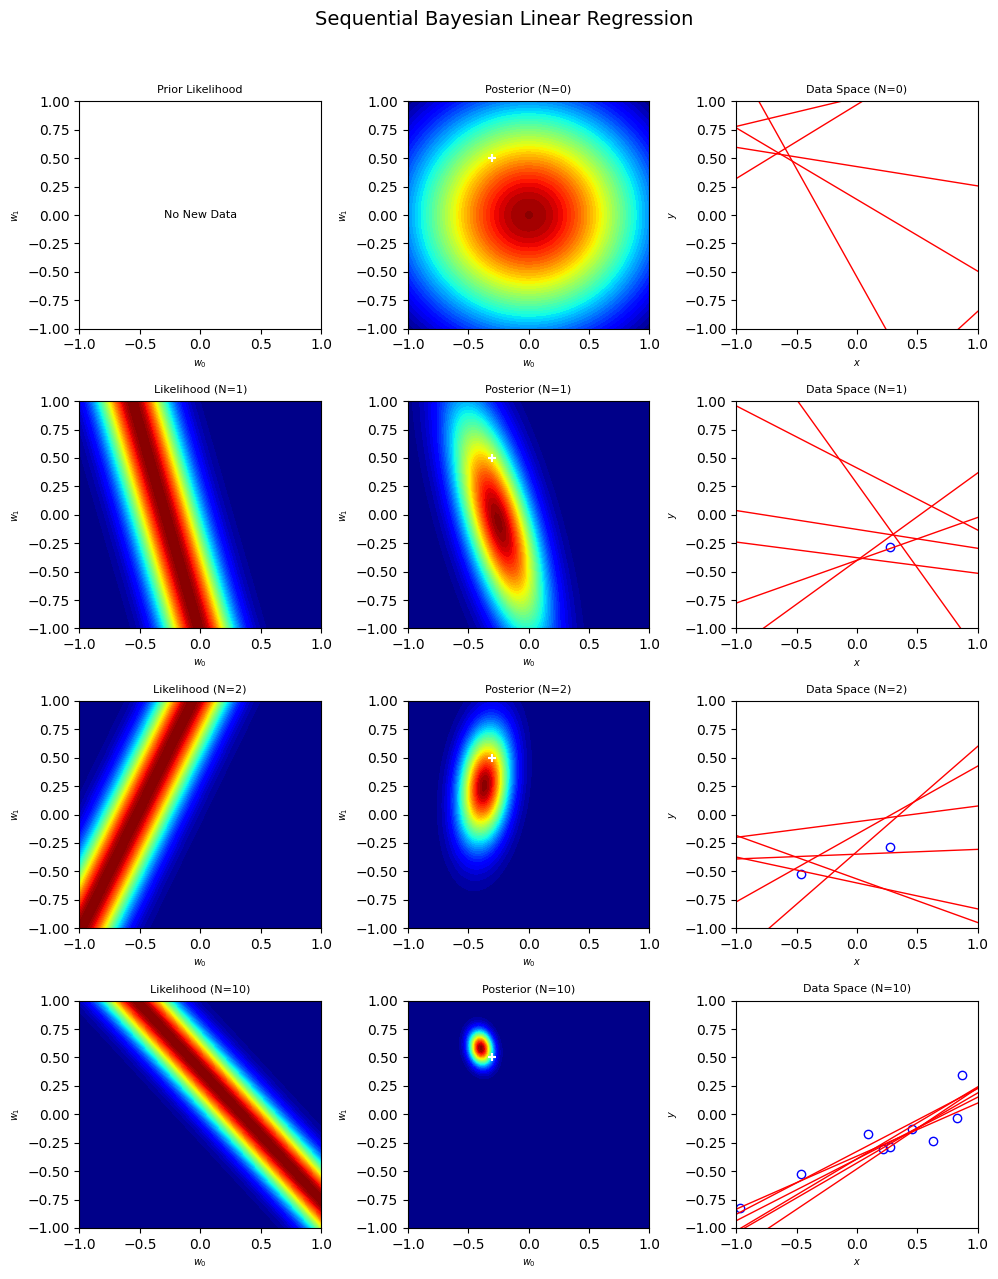

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# True parameters for generating synthetic data (the 'true' line)
w_true = np.array([-0.3, 0.5])  # w0 = -0.3, w1 = 0.5
noise_variance = 0.04
beta = 1 / noise_variance # Precision of the likelihood

# Initial Prior Parameters (for N=0 data points)

alpha = 2.0  # Precision of the prior (1/prior_variance).
S0_inv = alpha * np.identity(2)  # Initial precision matrix (2x2 identity)
m0 = np.zeros(2)  # Initial mean vector (2x1)

# Grid for plotting w0 and w1 (weights) distributions
W0, W1 = np.meshgrid(np.linspace(-1.0, 1.0, 100), np.linspace(-1.0, 1.0, 100))
W = np.array([W0.ravel(), W1.ravel()]).T  # (10000, 2) array of weight pairs

def generate_linear_data(num_points, seed = 0):
    """Generates synthetic data points according to the true linear model"""
    rng = np.random.default_rng(seed)
    X = rng.uniform(-1, 1, size=num_points)
    # y = w0 + w1*x + noise
    Y = w_true[0] + w_true[1] * X + rng.normal(0, np.sqrt(noise_variance), size=num_points)
    # The feature matrix Phi for all data points: Phi = [[1, x1], [1, x2], ...]
    Phi = np.vstack([np.ones(num_points), X]).T
    return X, Y, Phi

class BayesianLinearRegression:
    def __init__(self, m0, S0_inv, beta):
        self.m = m0 # mean vector
        self.S_inv = S0_inv # Precision matrix
        self.beta = beta
        self.S = np.linalg.inv(S0_inv)
        self.num_data = 0
        self.X_data = np.array([])
        self.Y_data = np.array([])

    def update(self, x_new, y_new):
        """
        Updates the posterior distribution with
        a new data point (closed form solution).
        """
        # Update data
        self.X_data = np.append(self.X_data, x_new)
        self.Y_data = np.append(self.Y_data, y_new)
        self.num_data += 1

        # Basis for the new x point: phi = [1, x_new]
        phi_n = np.array([1, x_new]).reshape(2, 1)

        # keep old precision & mean for the m_old_term
        S_inv_old = self.S_inv.copy()
        m_old = self.m.copy()

        # Update Precision Matrix (S_inv)
        # S_inv_new = S_inv_old + beta * phi_n * phi_n.T
        self.S_inv = self.S_inv + self.beta * (phi_n @ phi_n.T)

        # Update Covariance Matrix (S)
        self.S = np.linalg.inv(self.S_inv)

        # Update Mean Vector (m)
        # m_new = S_new @ (S_inv_old @ m_old + beta * y_new * phi_n)
        m_old_term = S_inv_old @ m_old
        # phi_n is 2x1, need 1D array for addition --> need flatten()
        new_data_term = self.beta * y_new * phi_n.flatten()
        self.m = self.S @ (m_old_term + new_data_term)

    def get_posterior_distribution(self):
        """
        Returns the mean vector and covariance matrix
        of the current posterior
        """
        return self.m, self.S

    def calculate_likelihood(self, x_new, y_new):
        """
        Calculates the likelihood p(y_new | w, x_new)
        for all W on the grid.
        """
        # For a fixed (x_new, y_new), the likelihood is a function of w:
        # p(y_new | w) ~ exp(-beta/2 * (y_new - (w0 + w1*x_new))^2)

        # W @ [1, x_new].T computes (w0 + w1*x_new) for all pairs in W
        mean_y = W @ np.array([1, x_new]).T

        # The exponent term (un-normalized)
        exponent = -0.5 * self.beta * (y_new - mean_y)**2

        # The likelihood is proportional to exp(exponent)
        # Normalize it for display
        likelihood = np.exp(exponent - np.max(exponent))
        return likelihood.reshape(W0.shape)

    def sample_from_posterior(self, num_samples=6):
        """
        Samples linear models (w0, w1) from the
        current posterior distribution
        """
        # Samples from a multivariate Gaussian distribution
        return multivariate_normal.rvs(self.m, self.S, size=num_samples)

def plot_results(bl_model, x_new, y_new, likelihood, num_data, ax):
    """
    Plots one row of the figure:
    Likelihood, Prior/Posterior, Data Space
    """

    # Get current posterior
    m_N, S_N = bl_model.get_posterior_distribution()

    # Likelihood Plot (Only if new data is provided)
    if likelihood is not None:
        ax[0].contourf(W0, W1, likelihood, levels=50, cmap='jet')
        ax[0].set_title(f'Likelihood (N={num_data})', fontsize=8)
    else:
        # Plot a blank space or "N/A" if there's no new point
        ax[0].text(0, 0, 'No New Data', ha='center', va='center', fontsize=8)

    # Prior/Posterior Plot
    # Calculates the PDF of the multivariate Gaussian N(m_N, S_N) on the W grid
    Z = multivariate_normal.pdf(W, mean=m_N, cov=S_N)
    ax[1].contourf(W0, W1, Z.reshape(W0.shape), levels=50, cmap='jet')
    ax[1].scatter(w_true[0], w_true[1], marker='+', color='white') # True weights
    ax[1].set_title(f'Posterior (N={num_data})', fontsize=8)

    # Data Space Plot
    # Plot data points
    ax[2].plot(bl_model.X_data, bl_model.Y_data, 'bo', mfc='none', markersize=6)

    # Sample linear functions from the posterior
    w_samples = bl_model.sample_from_posterior()
    x_plot = np.linspace(-1, 1, 100)

    for w_sample in w_samples:
        # y = w0 + w1*x
        y_sample = w_sample[0] + w_sample[1] * x_plot
        ax[2].plot(x_plot, y_sample, 'r-', linewidth=1)

    ax[2].set_title(f'Data Space (N={num_data})', fontsize=8)

    for i in range(3):
        ax[i].set_xlim(-1, 1)
        ax[i].set_ylim(-1, 1)
        ax[i].set_xlabel('$w_0$', fontsize=7)
        ax[i].set_ylabel('$w_1$', fontsize=7)
        if i == 2: # Data space uses x and y
            ax[i].set_xlabel('$x$', fontsize=7)
            ax[i].set_ylabel('$y$', fontsize=7)
            ax[i].set_xlim(-1, 1)
            ax[i].set_ylim(-1, 1)

# Generate a sequence of data points
X_data_all, Y_data_all, _ = generate_linear_data(num_points=10)

# Initialize the model with the prior
bl_model = BayesianLinearRegression(m0, S0_inv, beta)

# Set up the plot structure
fig, axes = plt.subplots(4, 3, figsize=(10, 13))
fig.suptitle('Sequential Bayesian Linear Regression', fontsize=14)

# Step 0: Prior (N=0)
plot_results(bl_model, None, None, None, 0, axes[0])
axes[0][0].set_title('Prior Likelihood', fontsize=8)

# Data points to observe sequentially
# data_indices = [0, 1, 9]
# Indices for the 1st, 2nd, and 10th total points
data_indices = range(10
row_index = 1
current_data_index = 0

for i in data_indices:
    # Observe one new data point
    x_new = X_data_all[data_indices[i]]
    y_new = Y_data_all[data_indices[i]]

    # Calculate Likelihood based on the new point (before updating the posterior)
    likelihood = bl_model.calculate_likelihood(x_new, y_new)

    # Update the posterior
    bl_model.update(x_new, y_new)

    # Plot the row (using the newly calculated likelihood and the new posterior)
    if row_index == 10: # correct row_index so plot 10 goes in row 3
      row_index = 3
    # Only plot for N = 1, 2, 10
    if i == 0 or i == 1 or i == 9:
      plot_results(bl_model, x_new, y_new, likelihood, bl_model.num_data, axes[row_index])

    row_index += 1

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Figure 3.8

Radial Basis Function Fitting

<>:138: SyntaxWarning: invalid escape sequence '\p'
<>:138: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-1299477495.py:138: SyntaxWarning: invalid escape sequence '\p'
  color='r', alpha=0.2, label='$\pm 2\sigma$')


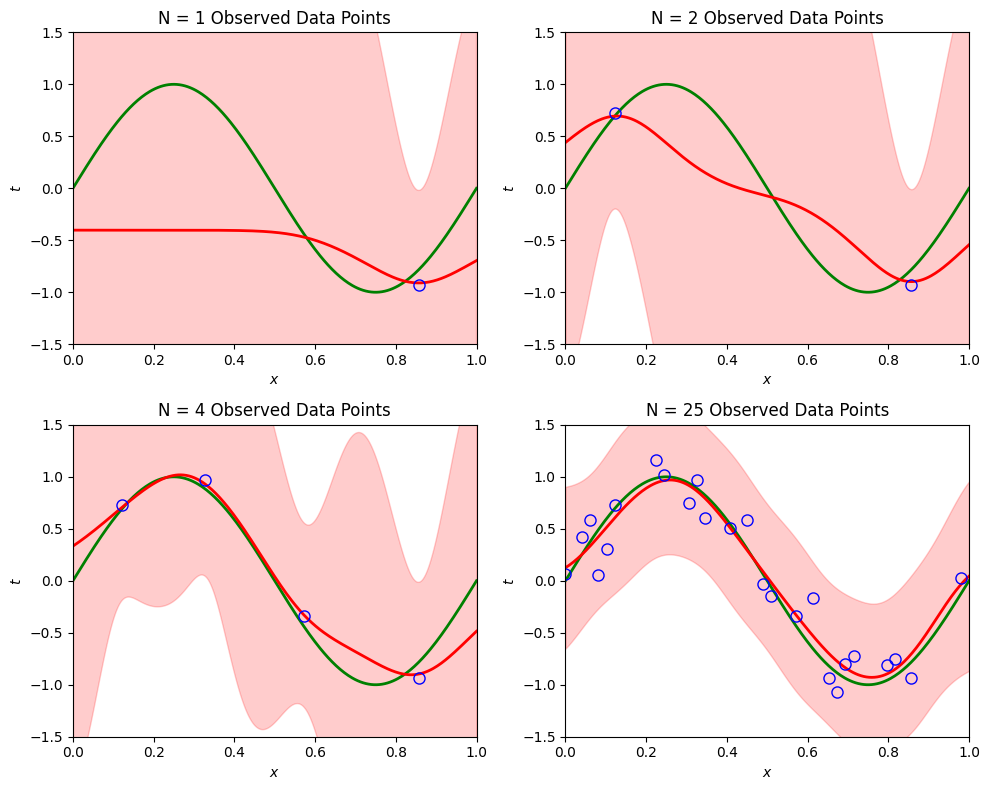

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


M = 9  # Total number of basis functions (including bias term phi_0(x)=1)
beta = 10.0  # Precision of the likelihood (1/noise_variance)
alpha = 0.5  # Precision of the prior

# Gaussian Basis Function Parameters
# M-1 centers for the Gaussian basis functions with fixed width s
mu_array = np.linspace(0, 1, M - 1)
s = 0.1

def gaussian_basis_function(x, mu, s):
    """Calculates a single Gaussian basis function output."""
    return np.exp(-0.5 * (x - mu)**2 / s**2)

def design_matrix(x_data, M, mu_array, s):
    """
    Expands the input x along the M basis functions.
    Phi is N x M, where N is number data points,
    M is basis functions.
    """
    if x_data.ndim == 0:
        x_data = np.array([x_data])
    # set column 0 to 1 for bias term
    Phi = np.ones((len(x_data), M))
    for j in range(1, M):
        Phi[:, j] = gaussian_basis_function(x_data, mu_array[j-1], s)
    return Phi

def true_function(x):
    """Generates true sinoid."""
    return np.sin(2 * np.pi * x)

def generate_sinusoid_data(num_points, beta, seed=42):
    """Generates synthetic sinusoidal data with Gaussian noise."""
    rng = np.random.default_rng(seed)
    X = np.linspace(0, 1, num_points)
    noise = rng.normal(0.0, 1.0 / np.sqrt(beta), size=num_points)
    T = true_function(X) + noise
    idx = np.arange(num_points)
    rng.shuffle(idx)
    return X[idx], T[idx]

def update_posterior(m_old, S_inv_old, Phi_new, t_new, beta):
    """
    Updates the Gaussian posterior parameters
    (mean, covariance) with new data
    """
    # Update Precision Matrix (S_inv)
    S_inv_new = S_inv_old + beta * Phi_new.T @ Phi_new

    # Update Covariance Matrix (S)
    S_new = np.linalg.inv(S_inv_new)

    # Update Mean Vector (m)
    m_new = S_new @ (S_inv_old @ m_old + beta * Phi_new.T @ t_new)

    return m_new, S_inv_new, S_new

def calculate_predictive_distribution(x_plot, m_N, S_N, M, mu_array, s, beta):
    """
    Calculates the predictive mean and variance for a range of x values
    """
    # Design matrix for the plot points
    Phi_plot = design_matrix(x_plot, M, mu_array, s)

    # Predictive Mean (The red line): m(x) = Phi_plot @ m_N
    predictive_mean = Phi_plot @ m_N

    # Calculate weight uncertainty
    uncertainty_term = np.sum(Phi_plot @ S_N * Phi_plot, axis=1)

    # Predictive Variance: Red shaded area
    # n= noise variance + weight uncertainty
    predictive_variance = 1.0/beta + uncertainty_term

    return predictive_mean, predictive_variance

# Initialize the Prior (N=0)
m_N = np.zeros(M)
S_N_inv = alpha * np.identity(M)
S_N = np.linalg.inv(S_N_inv)

# Lists to store observed data
X_data = np.array([])
T_data = np.array([])
data_points_to_observe = [1, 2, 4, 25]

# Generate all data points needed
X_all, T_all = generate_sinusoid_data(num_points=50, beta=20)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
x_plot = np.linspace(0, 1, 300)

current_data_idx = 0
for i, N_target in enumerate(data_points_to_observe):
    ax = axes[i]

    # Get the new data chunk
    num_new_points = N_target - current_data_idx
    if num_new_points > 0:
        x_new = X_all[current_data_idx:N_target]
        t_new = T_all[current_data_idx:N_target]

        # Update data storage
        X_data = np.append(X_data, x_new)
        T_data = np.append(T_data, t_new)

        # Update the posterior distribution
        Phi_new = design_matrix(x_new, M, mu_array, s)
        m_N, S_N_inv, S_N = update_posterior(m_N, S_N_inv, Phi_new, t_new, beta)

        current_data_idx = N_target

    # Calculate Predictive Distribution
    mean, variance = calculate_predictive_distribution(x_plot, m_N, S_N, M, mu_array, s, beta)
    std_dev = np.sqrt(variance)

    # True Function (Green line)
    ax.plot(x_plot, true_function(x_plot), 'g-', linewidth=2, label='True Function')

    # Predictive Mean (Red line)
    ax.plot(x_plot, mean, 'r-', linewidth=2, label='Predictive Mean')

    # Predictive Distribution (Pink shaded area: Mean +/- 2 * Std Dev)
    ax.fill_between(x_plot, mean - 2 * std_dev, mean + 2 * std_dev,
                    color='r', alpha=0.2, label='$\pm 2\sigma$')

    # Observed Data Points (Blue circles)
    ax.plot(X_data, T_data, 'bo', markerfacecolor='none', markersize=8)

    # Set plot limits and title
    ax.set_xlim(0, 1)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_title(f'N = {len(X_data)} Observed Data Points')

plt.tight_layout()
plt.show()

## Stretch Goal: Evidence Approximation


Testing evidence approximation on RBF data...
Starting evidence approximation with 25 data points, 9 basis functions
Iter 1: alpha=4.3727, beta=19.0880, gamma=8.02
Iter 2: alpha=4.6472, beta=20.1109, gamma=6.60
Iter 3: alpha=4.6460, beta=20.1127, gamma=6.59
Iter 4: alpha=4.6461, beta=20.1127, gamma=6.59
Iter 5: alpha=4.6461, beta=20.1127, gamma=6.59
Converged after 5 iterations!

Optimized hyperparameters:
  alpha = 4.646051 (was 0.5)
  beta  = 20.112658 (was 10.0)
  Effective parameters: gamma = 6.59 out of 9 total

Comparing fixed vs optimized hyperparameters...


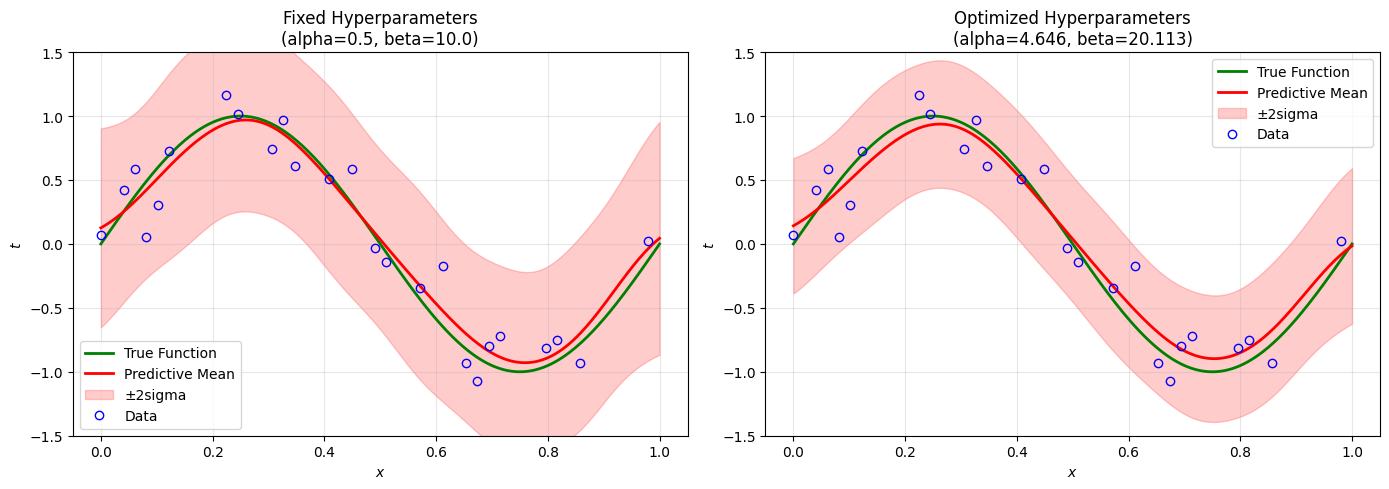

In [ ]:
def evidence_approximation(Phi, t, alpha_0=1.0, beta_0=1.0, max_iter=50, tol=1e-6):
    """
    Estimate hyperparameters alpha and beta using evidence approximation.

    Parameters:
    Phi: Design matrix (N x M)
    t: Target values (N,)
    alpha_0, beta_0: Initial values for hyperparameters
    max_iter: Maximum iterations
    tol: Convergence tolerance

    Returns:
    alpha_opt, beta_opt: Optimized hyperparameters
    m_N: Posterior mean with optimized hyperparameters
    gamma: Effective number of parameters
    """

    N, M = Phi.shape
    alpha = alpha_0
    beta = beta_0

    print(f"Starting evidence approximation with {N} data points, {M} basis functions")

    for i in range(max_iter):
        # --- E-step: Compute posterior with current alpha, beta ---
        # Posterior precision: S_N^{-1} = alpha * I + beta * Phi^T @ Phi
        S_N_inv = alpha * np.eye(M) + beta * Phi.T @ Phi
        S_N = np.linalg.inv(S_N_inv)

        # Posterior mean: m_N = beta * S_N @ Phi.T @ t
        m_N = beta * S_N @ Phi.T @ t

        # Compute eigenvalues for gamma calculation
        # gamma = sum_{i=1}^M (lambda_i / (alpha + lambda_i))
        # where lambda_i are eigenvalues of beta * Phi.T @ Phi
        eigenvalues = np.linalg.eigvalsh(beta * Phi.T @ Phi)
        gamma = np.sum(eigenvalues / (alpha + eigenvalues))

        # --- M-step: Update alpha and beta ---
        alpha_old, beta_old = alpha, beta

        # Equation 3.92: alpha = gamma / (m_N^T @ m_N)
        alpha = gamma / (m_N.T @ m_N)

        # Equation 3.95: beta = (N - gamma) / sum((t_n - m_N^T @ phi_n)^2)
        predictions = Phi @ m_N
        residuals = t - predictions
        beta = (N - gamma) / (residuals.T @ residuals)

        # Check convergence
        alpha_change = abs(alpha - alpha_old) / alpha_old
        beta_change = abs(beta - beta_old) / beta_old

        print(f"Iter {i+1}: alpha={alpha:.4f}, beta={beta:.4f}, gamma={gamma:.2f}")

        if alpha_change < tol and beta_change < tol:
            print(f"Converged after {i+1} iterations!")
            break
    else:
        print(f"Reached maximum iterations ({max_iter})")

    return alpha, beta, m_N, gamma

# Test evidence approximation on RBF data
print("\nTesting evidence approximation on RBF data...")

# Use first 25 data points for testing
X_test = X_all[:25]
T_test = T_all[:25]
Phi_test = design_matrix(X_test, M, mu_array, s)

# Run evidence approximation
alpha_opt, beta_opt, m_opt, gamma_opt = evidence_approximation(
    Phi_test, T_test, alpha_0=0.1, beta_0=10.0, max_iter=50)

print(f"\nOptimized hyperparameters:")
print(f"  alpha = {alpha_opt:.6f} (was {alpha})")
print(f"  beta  = {beta_opt:.6f} (was {beta})")
print(f"  Effective parameters: gamma = {gamma_opt:.2f} out of {M} total")

# Compare predictive distributions with fixed vs optimized hyperparameters
print("\nComparing fixed vs optimized hyperparameters...")

# Calculate predictive distribution with OPTIMIZED hyperparameters
S_N_opt_inv = alpha_opt * np.eye(M) + beta_opt * Phi_test.T @ Phi_test
S_N_opt = np.linalg.inv(S_N_opt_inv)
m_N_opt = beta_opt * S_N_opt @ Phi_test.T @ T_test

mean_opt, var_opt = calculate_predictive_distribution(x_plot, m_N_opt, S_N_opt, M, mu_array, s, beta_opt)
std_opt = np.sqrt(var_opt)

# Calculate predictive distribution with ORIGINAL hyperparameters
# (Re-calculate with the test data only for fair comparison)
m_N_orig = np.zeros(M)
S_N_inv_orig = alpha * np.eye(M)
S_N_orig = np.linalg.inv(S_N_inv_orig)

# Update posterior with the same test data using original hyperparameters
m_N_orig, S_N_inv_orig, S_N_orig = update_posterior(m_N_orig, S_N_inv_orig, Phi_test, T_test, beta)

mean_orig, var_orig = calculate_predictive_distribution(x_plot, m_N_orig, S_N_orig, M, mu_array, s, beta)
std_orig = np.sqrt(var_orig)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot with original hyperparameters
ax1.plot(x_plot, true_function(x_plot), 'g-', linewidth=2, label='True Function')
ax1.plot(x_plot, mean_orig, 'r-', linewidth=2, label='Predictive Mean')
ax1.fill_between(x_plot, mean_orig - 2*std_orig, mean_orig + 2*std_orig,
                color='red', alpha=0.2, label='±2sigma')
ax1.plot(X_test, T_test, 'bo', markerfacecolor='none', markersize=6, label='Data')
ax1.set_title(f'Fixed Hyperparameters\n(alpha={alpha}, beta={beta})', fontsize=12)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$t$')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-1.5, 1.5)

# Plot with optimized hyperparameters
ax2.plot(x_plot, true_function(x_plot), 'g-', linewidth=2, label='True Function')
ax2.plot(x_plot, mean_opt, 'r-', linewidth=2, label='Predictive Mean')
ax2.fill_between(x_plot, mean_opt - 2*std_opt, mean_opt + 2*std_opt,
                color='red', alpha=0.2, label='±2sigma')
ax2.plot(X_test, T_test, 'bo', markerfacecolor='none', markersize=6, label='Data')
ax2.set_title(f'Optimized Hyperparameters\n(alpha={alpha_opt:.3f}, beta={beta_opt:.3f})', fontsize=12)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$t$')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()